In [1]:
import numpy
import torch
import torch.nn as nn
from collections import OrderedDict
import os
import sys
import warnings
from torch.utils.data import DataLoader
import argparse
import time
import copy
import math
import torchvision.utils as vision_utils
import json
import numpy as np
from torch.distributions import bernoulli
from scipy import linalg
import torchvision.datasets as _datasets
import torchvision.transforms as _transforms
import matplotlib.pyplot as plt
import shutil

from data import Binarize, Smooth, load_mnist, get_sampler
from evals import compute_mu_sigma_pretrained_model, calculate_frechet_distance, _calculate_metrics, get_metrics
from losses import get_disciminator_loss, get_generator_loss
from model import DiscriminatorCNN28, GeneratorCNN28, MLP_mnist, pretrained_mnist_model
from trainer import train, train_SGD_manual
from updates import Lookahead, update_avg_gen, update_ema_gen
from utils import save_models, get_plot_func, get_num_params

In [2]:
a = 1

In [3]:
_NOISE_DIM = 8
_H_FILTERS = 4

In [4]:
G = GeneratorCNN28(noise_dim=_NOISE_DIM, h_filters=_H_FILTERS, out_tanh=True)
D = DiscriminatorCNN28(h_filters=_H_FILTERS, spectral_norm=False, img_size=28)

In [5]:
get_num_params(G)

12672

In [6]:
get_num_params(D)

2768

Loading trained model from ./drive/My Drive/Data/models/mnist.pth
Iter 0: Mean proba from D(G(z)): 0.5546 +/- 0.0844


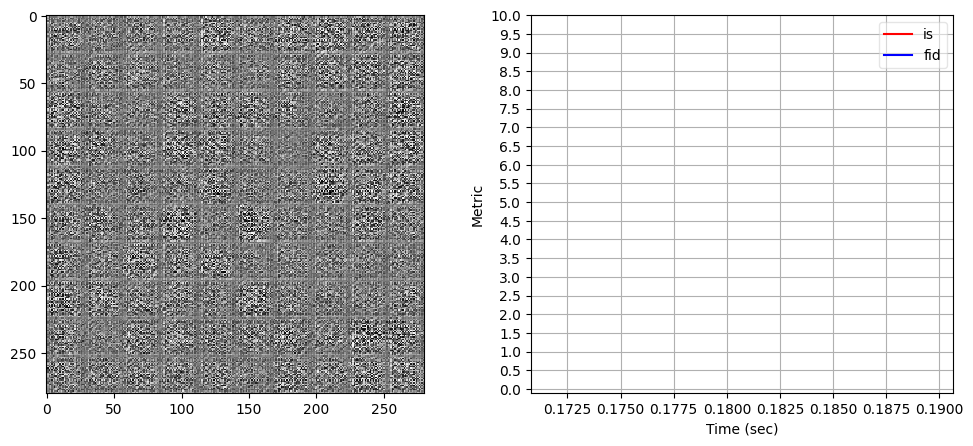

Iter 5000: Mean proba from D(G(z)): 0.2827 +/- 0.0790


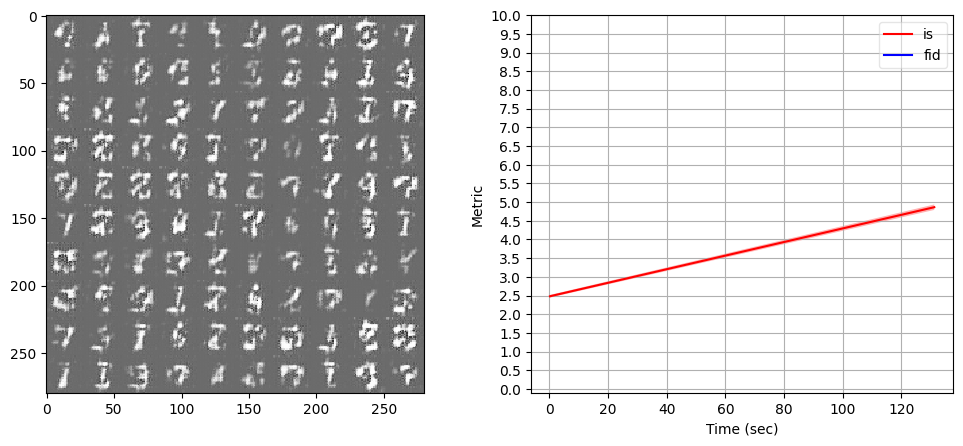

Iter 10000: Mean proba from D(G(z)): 0.4960 +/- 0.1245


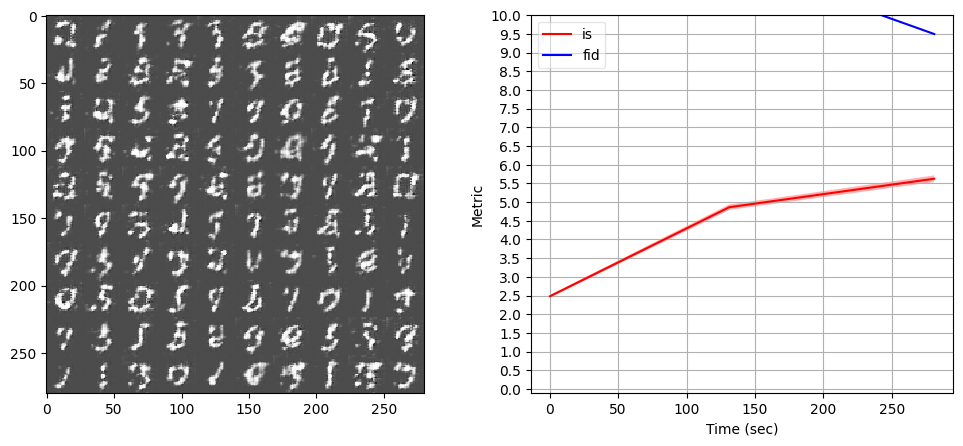

Iter 15000: Mean proba from D(G(z)): 0.2625 +/- 0.1333


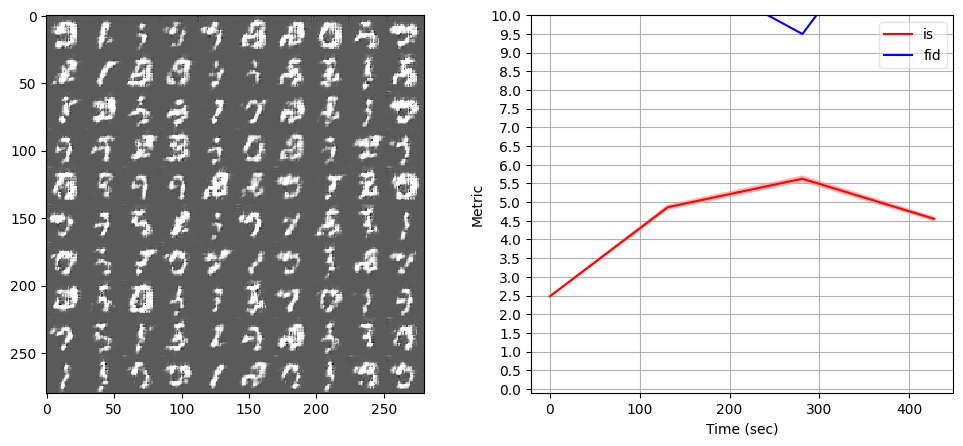

Iter 20000: Mean proba from D(G(z)): 0.1050 +/- 0.0651


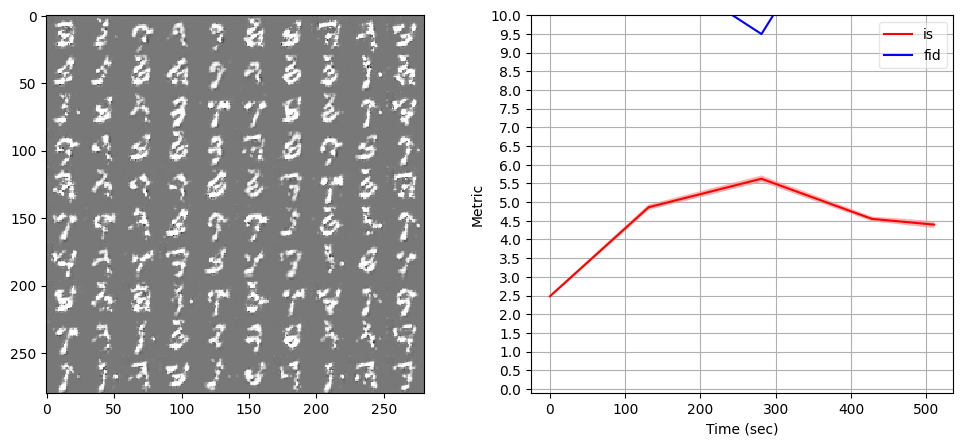

Iter 25000: Mean proba from D(G(z)): 0.2009 +/- 0.1011


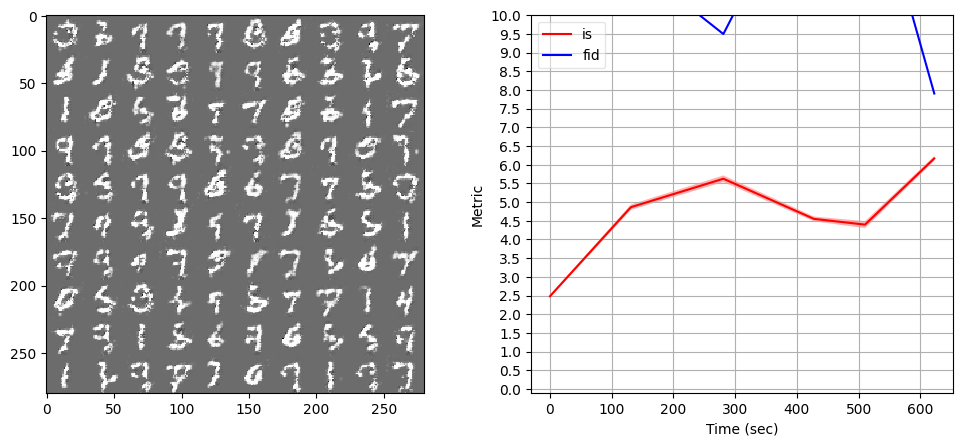

Iter 30000: Mean proba from D(G(z)): 0.2422 +/- 0.1122


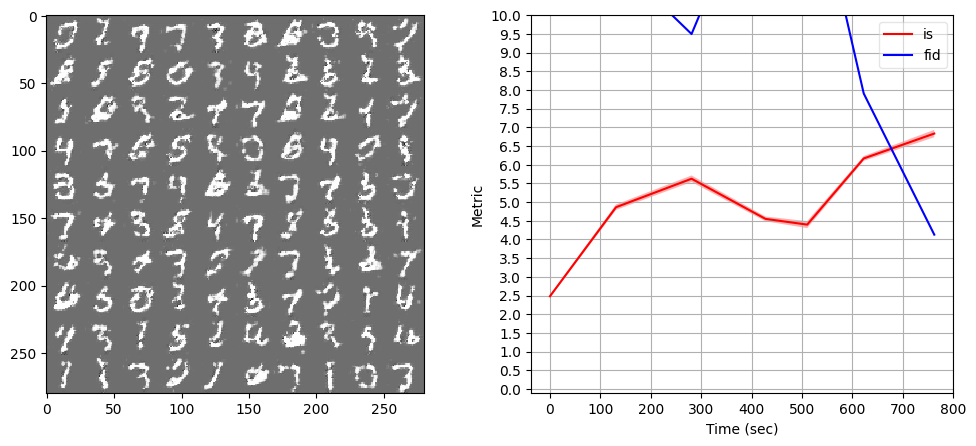

Iter 35000: Mean proba from D(G(z)): 0.4184 +/- 0.1294


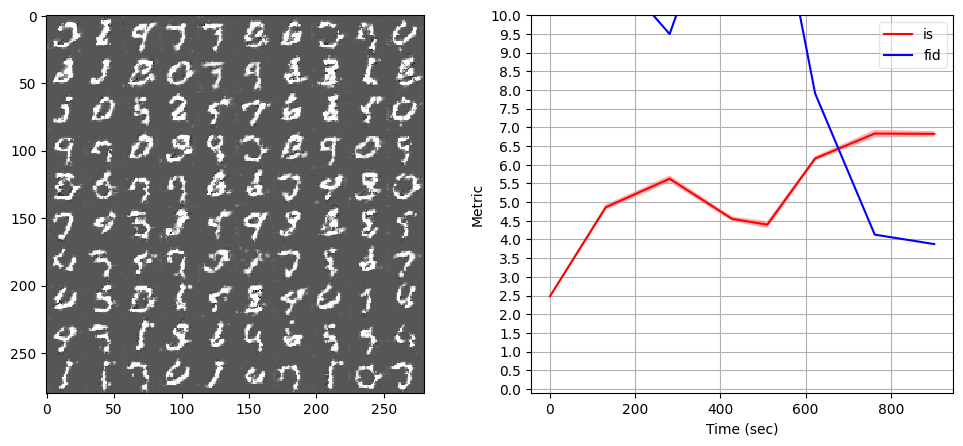

Iter 40000: Mean proba from D(G(z)): 0.5431 +/- 0.1493


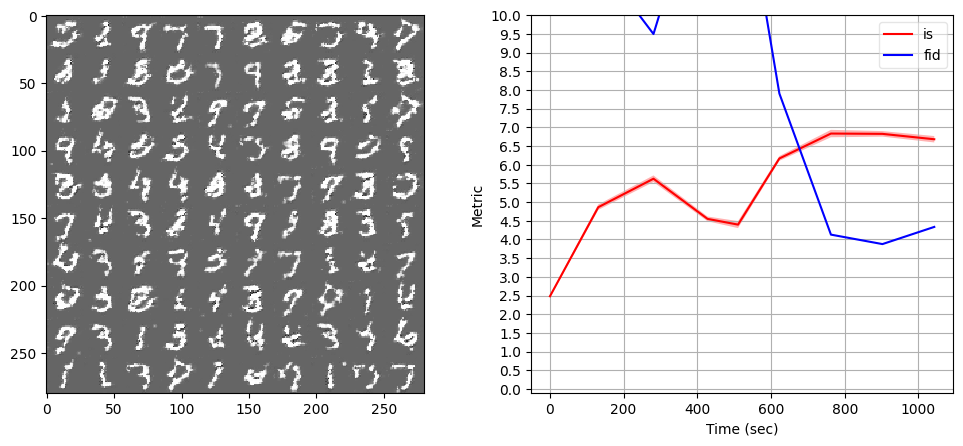

Iter 45000: Mean proba from D(G(z)): 0.3535 +/- 0.1461


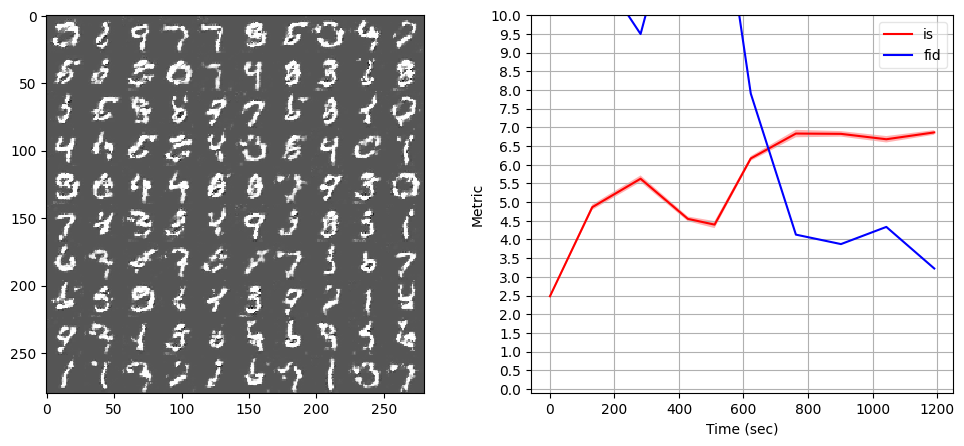

Iter 50000: Mean proba from D(G(z)): 0.4290 +/- 0.1589


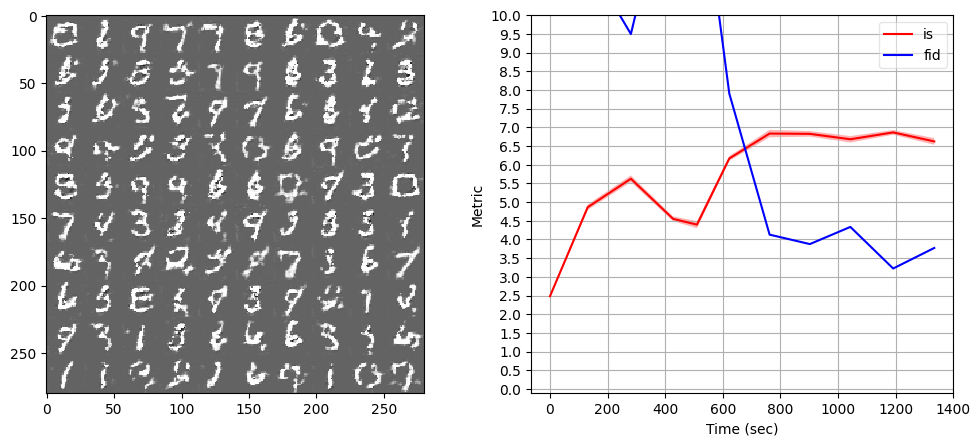

Iter 55000: Mean proba from D(G(z)): 0.3967 +/- 0.1362


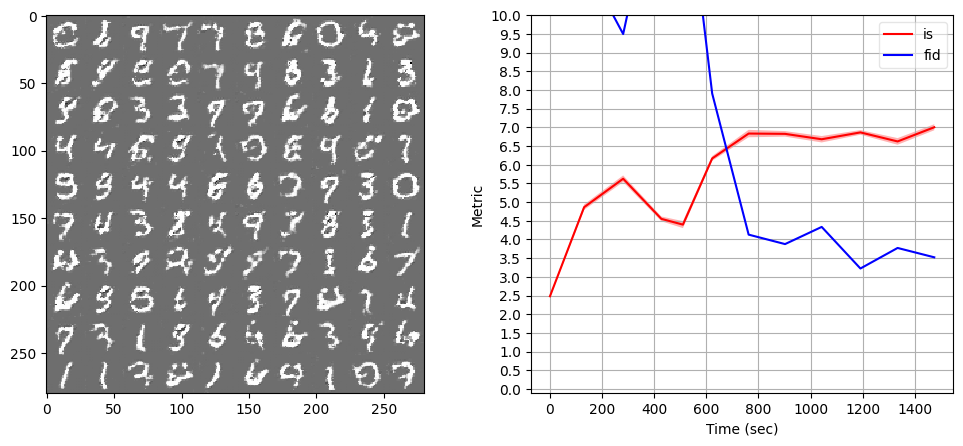

Iter 60000: Mean proba from D(G(z)): 0.2351 +/- 0.1197


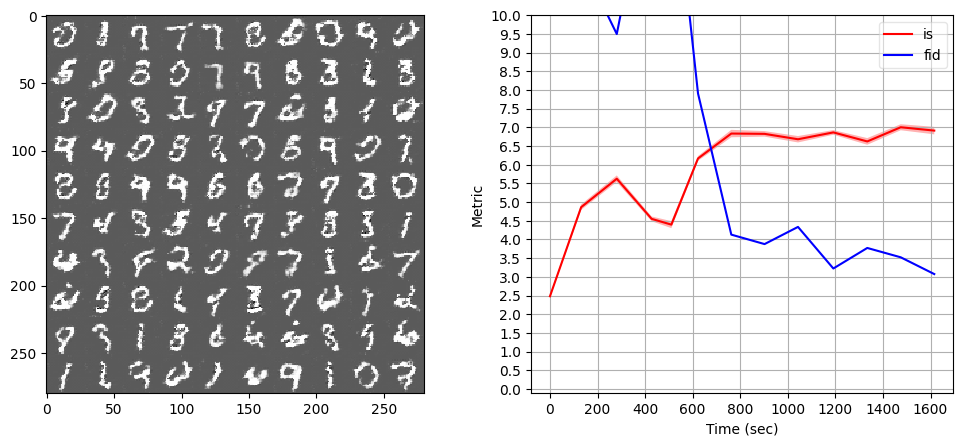

Iter 65000: Mean proba from D(G(z)): 0.4163 +/- 0.1494


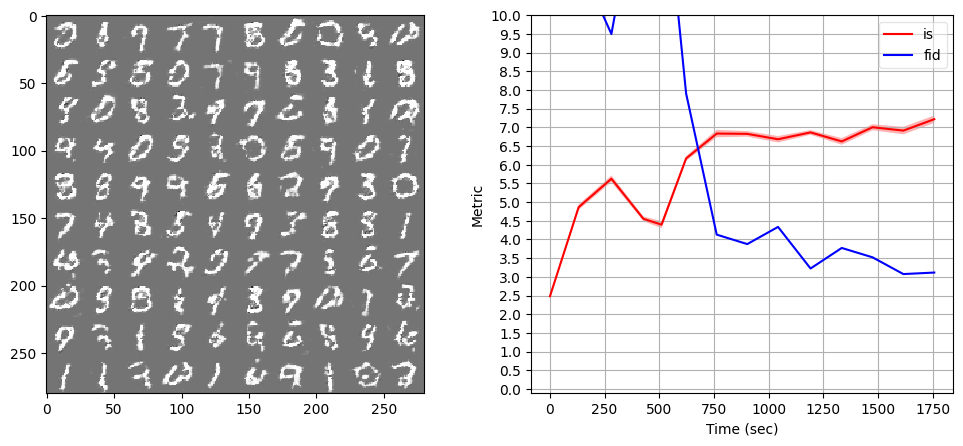

Iter 70000: Mean proba from D(G(z)): 0.4930 +/- 0.1541


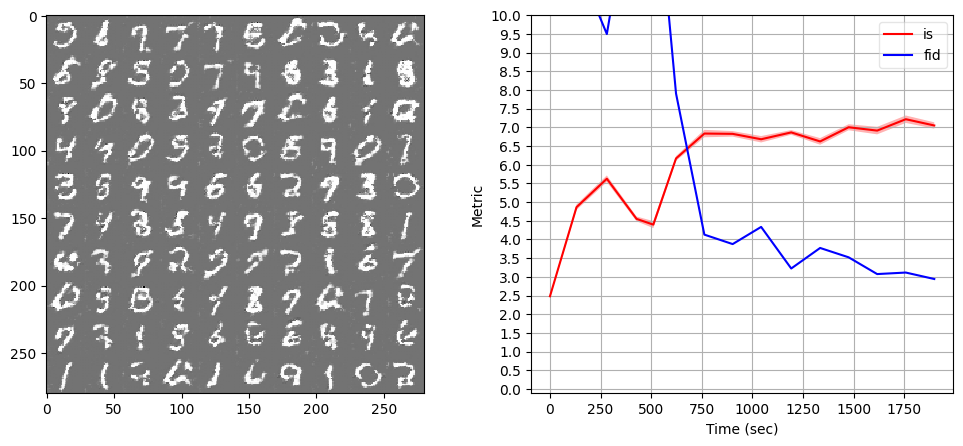

Iter 75000: Mean proba from D(G(z)): 0.2075 +/- 0.1077


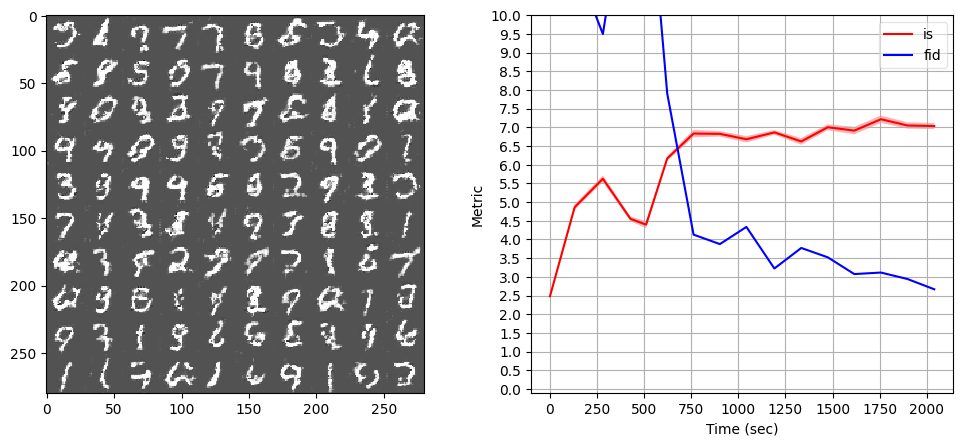

Iter 80000: Mean proba from D(G(z)): 0.4671 +/- 0.1545


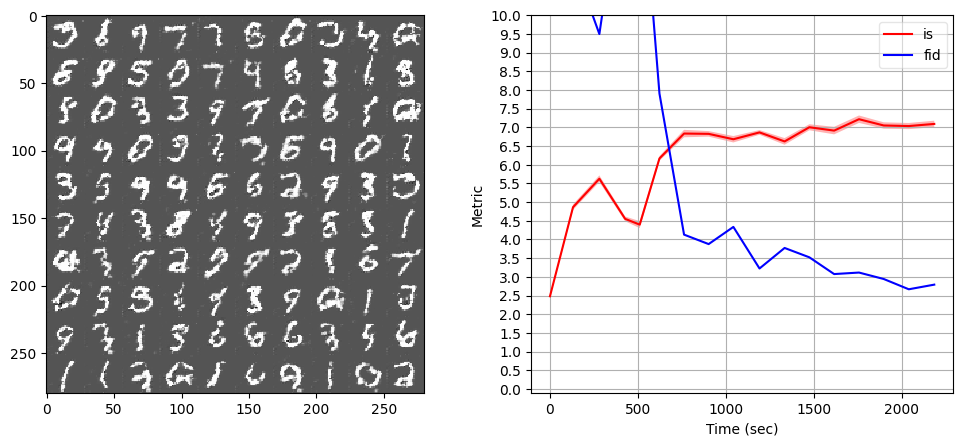

Iter 85000: Mean proba from D(G(z)): 0.3141 +/- 0.1394


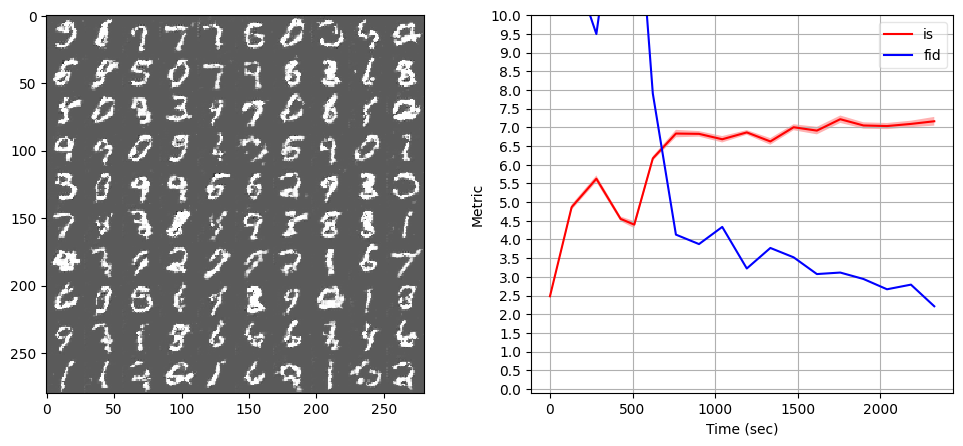

Iter 90000: Mean proba from D(G(z)): 0.5254 +/- 0.1594


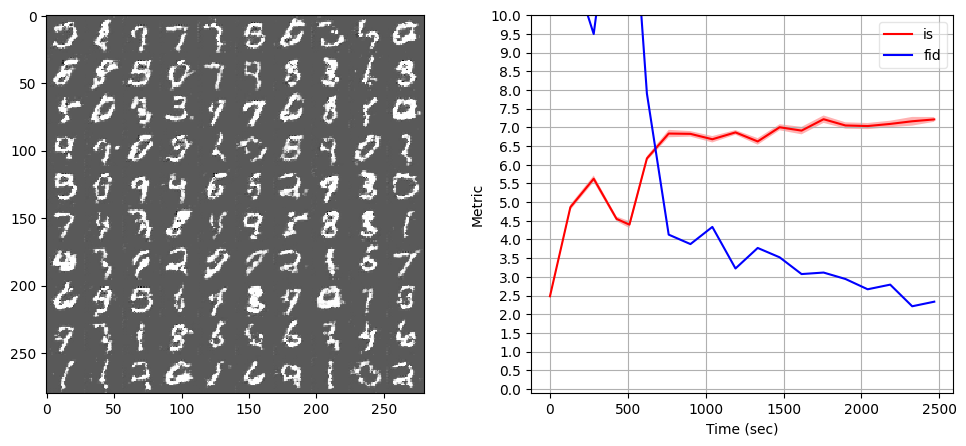

Iter 95000: Mean proba from D(G(z)): 0.4511 +/- 0.1561


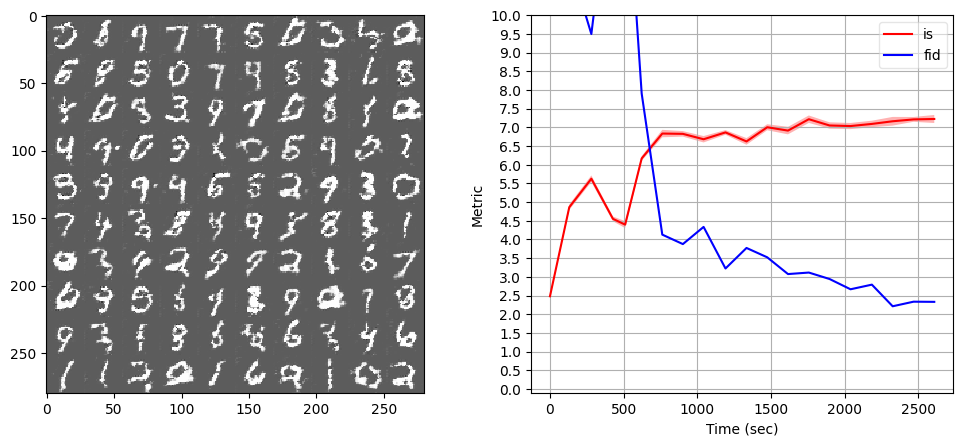

Iter 99999: Mean proba from D(G(z)): 0.3564 +/- 0.1601


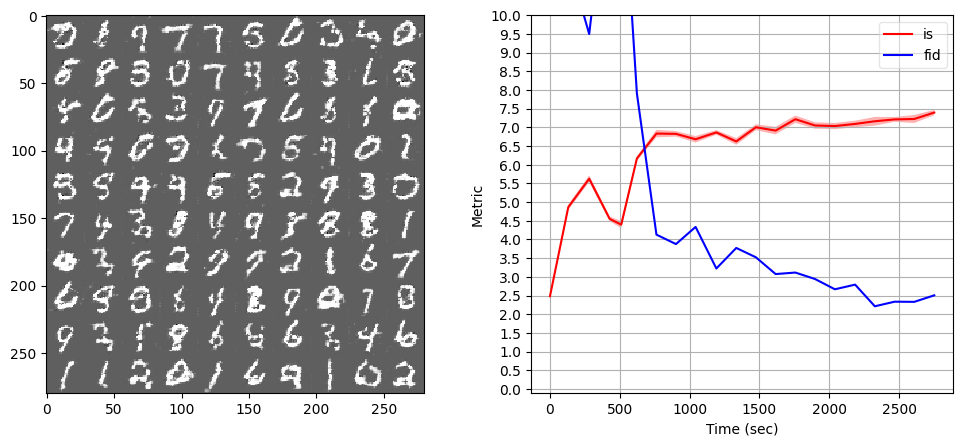

In [9]:
args = dict(iterations = 100000,
            batch_size = 128,
            lrD = 0.001,
            lrG = 0.001,
            eval_every = 5000,
            n_workers = 4,
            device = 'cuda',)


for k in range(1,1+1):
  exp_key = f"iter{args['iterations']}_bs{args['batch_size']}_lrD{args['lrD']}" + \
            f"_lrG{args['lrG']}" + f"_ee{args['eval_every']}"
  out_dir = f"/home/mila/t/tianyu.zhang/GAN_LOLA/drive/My Drive/results/final/{exp_key}/{k}/"

  shutil.rmtree(out_dir, ignore_errors=True)
  if not os.path.exists(out_dir):
    os.makedirs(out_dir)

  with open(os.path.join(out_dir, 'args.json'), 'w') as fs:
    json.dump(args, fs)

  dataset = load_mnist(_data_root='datasets', binarized=False)

  plot_func = get_plot_func(out_dir=out_dir, 
                            img_size=dataset[0][0].size(),
                            num_samples_eval=10000)

  G = GeneratorCNN28(noise_dim=_NOISE_DIM, h_filters=_H_FILTERS, out_tanh=True)
  D = DiscriminatorCNN28(h_filters=_H_FILTERS, spectral_norm=False, img_size=28)

  train_SGD_manual(G, D, dataset, 
        iterations=args['iterations'], 
        batch_size=args['batch_size'], 
        lrD=args['lrD'], 
        lrG=args['lrG'], 
        eval_every=args['eval_every'], 
        n_workers=args['n_workers'], 
        device=torch.device(args['device']), 
        plot_func=plot_func,
        out_dir=out_dir)

Loading trained model from ./drive/My Drive/Data/models/mnist.pth
Iter 0: Mean proba from D(G(z)): 0.4906 +/- 0.0848


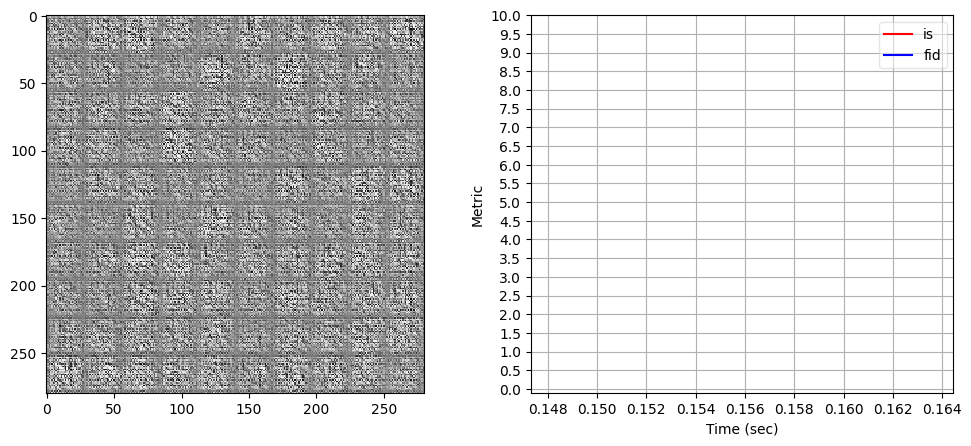

In [ ]:
args = dict(iterations = 100000,
            batch_size = 128,
            lrD = 0.0001,
            lrG = 0.0001,
            eval_every = 5000,
            n_workers = 4,
            device = 'cuda',)


for k in range(1,1+1):
  exp_key = f"iter{args['iterations']}_bs{args['batch_size']}_lrD{args['lrD']}" + \
            f"_lrG{args['lrG']}" + f"_ee{args['eval_every']}"
  out_dir = f"/home/mila/t/tianyu.zhang/GAN_LOLA/drive/My Drive/results/final/{exp_key}/{k}/"

  shutil.rmtree(out_dir, ignore_errors=True)
  if not os.path.exists(out_dir):
    os.makedirs(out_dir)

  with open(os.path.join(out_dir, 'args.json'), 'w') as fs:
    json.dump(args, fs)

  dataset = load_mnist(_data_root='datasets', binarized=False)

  plot_func = get_plot_func(out_dir=out_dir, 
                            img_size=dataset[0][0].size(),
                            num_samples_eval=10000)

  G = GeneratorCNN28(noise_dim=_NOISE_DIM, h_filters=_H_FILTERS, out_tanh=True)
  D = DiscriminatorCNN28(h_filters=_H_FILTERS, spectral_norm=False, img_size=28)

  train_SGD_manual(G, D, dataset, 
        iterations=args['iterations'], 
        batch_size=args['batch_size'], 
        lrD=args['lrD'], 
        lrG=args['lrG'], 
        eval_every=args['eval_every'], 
        n_workers=args['n_workers'], 
        device=torch.device(args['device']), 
        plot_func=plot_func,
        out_dir=out_dir)